Loading IRIS dataset...

--- Standard Batch Training ---

=== Starting Sequential Training (Class Incremental) ===
checkpoint directory created: ./model
saving model version 0.0

--- Training on Class 0 only ---


| train_loss: 0.00e+00 | test_loss: 0.00e+00 | reg: 7.75e+00 | : 100%|█| 30/30 [00:00<00:00, 47.32it


saving model version 0.1


| train_loss: 0.00e+00 | test_loss: 0.00e+00 | reg: 1.98e+01 | : 100%|█| 30/30 [00:00<00:00, 107.14i


  KAN Global Test Acc: 0.3333
  MLP Global Test Acc: 0.3333

--- Training on Class 1 only ---


| train_loss: 0.00e+00 | test_loss: 0.00e+00 | reg: 1.42e+01 | : 100%|█| 30/30 [00:00<00:00, 49.75it


saving model version 0.2


| train_loss: 0.00e+00 | test_loss: 0.00e+00 | reg: 1.77e+01 | : 100%|█| 30/30 [00:00<00:00, 104.89i


  KAN Global Test Acc: 0.3000
  MLP Global Test Acc: 0.3000

--- Training on Class 2 only ---


| train_loss: 5.53e-05 | test_loss: 1.04e-04 | reg: 1.76e+01 | : 100%|█| 30/30 [00:00<00:00, 44.78it


saving model version 0.3


| train_loss: 5.53e-05 | test_loss: 0.00e+00 | reg: 1.70e+01 | : 100%|█| 30/30 [00:00<00:00, 95.19it


  KAN Global Test Acc: 0.3667
  MLP Global Test Acc: 0.3667


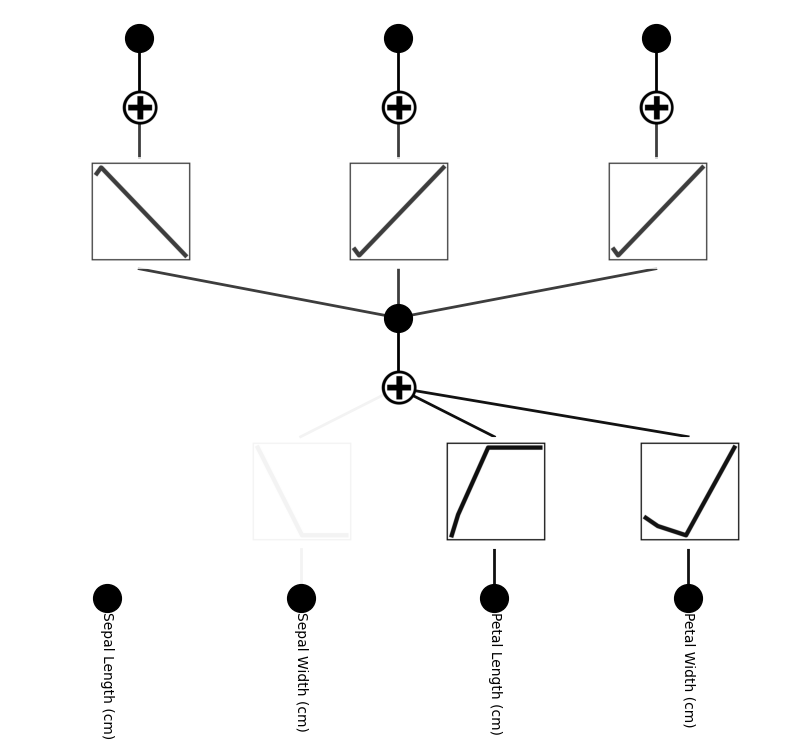

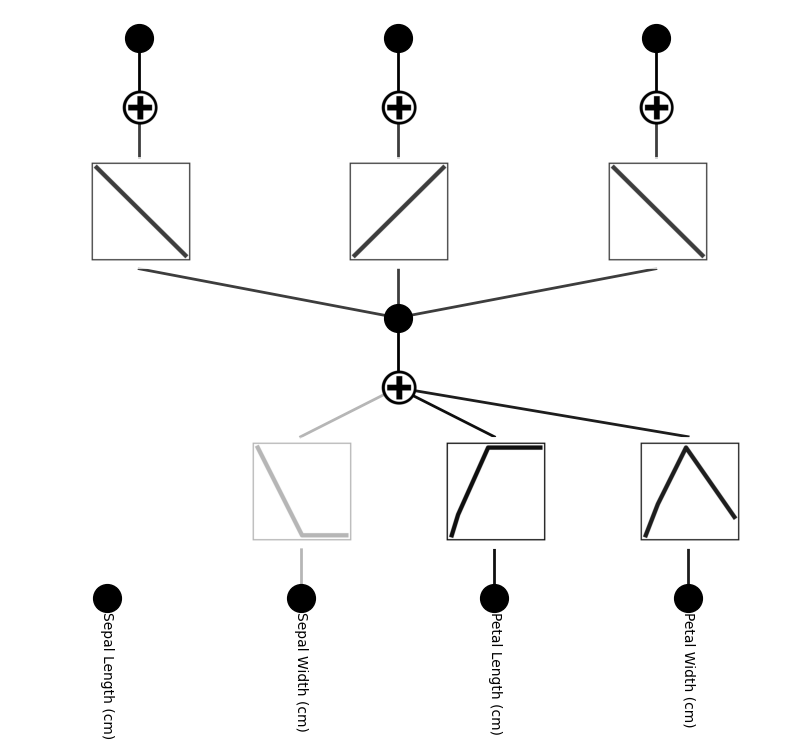

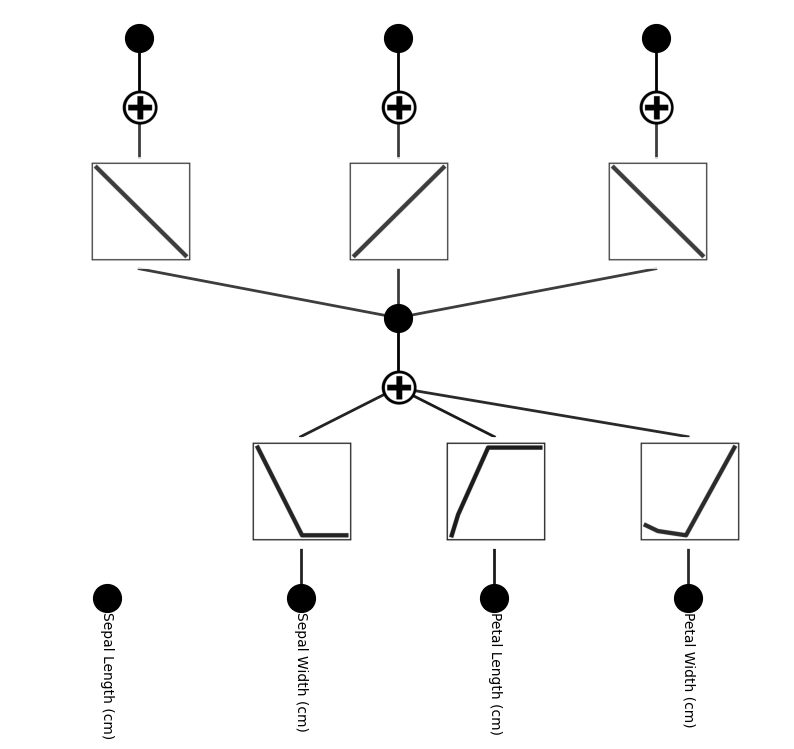

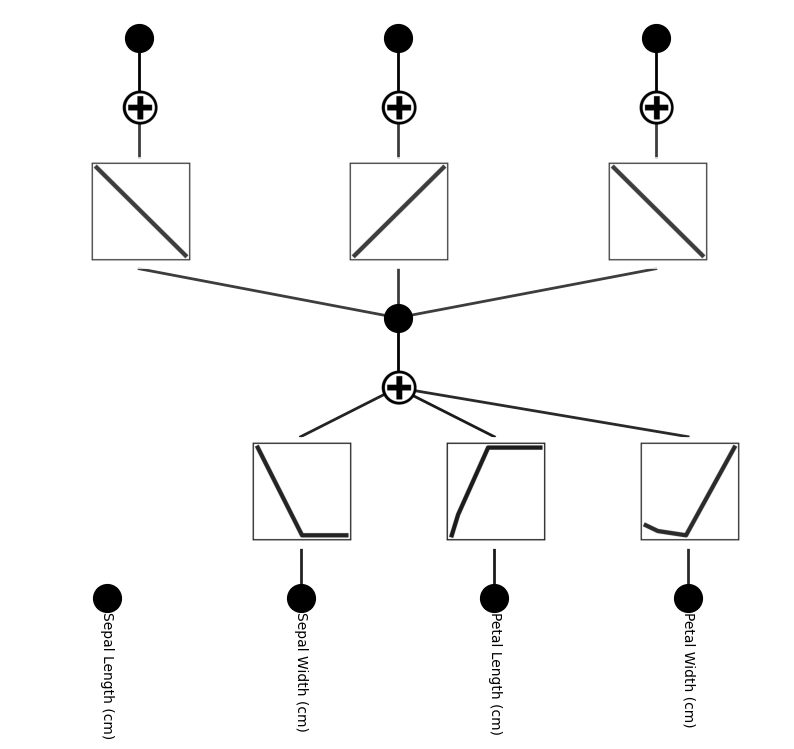

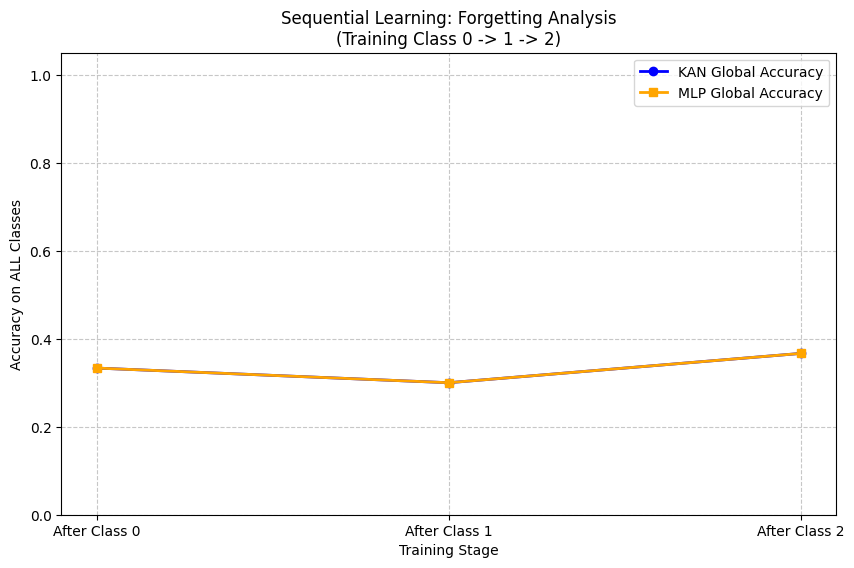

In [11]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from kan import *
from kan import KAN
from kan.MLP import MLP
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from IPython.display import display, Math
from sympy import latex

# Select Device
device = torch.device('cpu') # Change to 'cuda' if desired

# --- 1. Dataset Preparation Helper ---
def get_iris_dataset():
    """
    Loads Iris dataset and formats it into the dictionary structure
    required by KAN/MLP.
    """
    print("Loading IRIS dataset...")
    iris = load_iris()
    X = iris.data
    y = iris.target

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    dataset = {}
    dtype = torch.get_default_dtype()

    dataset['train_input'] = torch.from_numpy(X_train).type(dtype).to(device)
    dataset['test_input'] = torch.from_numpy(X_test).type(dtype).to(device)
    dataset['train_label'] = torch.from_numpy(y_train).type(torch.long).to(device)
    dataset['test_label'] = torch.from_numpy(y_test).type(torch.long).to(device)

    return dataset

def get_class_subset(dataset, class_label):
    """
    Filters the dataset to only include samples belonging to a specific class.
    Used for sequential training.
    """
    subset = {}
    # Filter Train
    train_mask = (dataset['train_label'] == class_label)
    subset['train_input'] = dataset['train_input'][train_mask]
    subset['train_label'] = dataset['train_label'][train_mask]

    # Filter Test (We filter test too for the local training step metrics,
    # but usually we evaluate on the global test set to check forgetting)
    test_mask = (dataset['test_label'] == class_label)
    subset['test_input'] = dataset['test_input'][test_mask]
    subset['test_label'] = dataset['test_label'][test_mask]

    return subset

# --- 2. Train MLP Function (Standard) ---
def train_mlp(dataset, width, steps=20, seed=42):
    print(f"Training MLP (Width: {width})...")
    model = MLP(width=width, seed=seed, device=device)
    dtype = torch.get_default_dtype()

    def train_acc():
        pred = torch.argmax(model(dataset['train_input']), dim=1)
        return torch.mean((pred == dataset['train_label']).type(dtype))

    def test_acc():
        pred = torch.argmax(model(dataset['test_input']), dim=1)
        return torch.mean((pred == dataset['test_label']).type(dtype))

    results = model.fit(dataset, opt="LBFGS", steps=steps, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())
    print(f"MLP Final Test Acc: {results['test_acc'][-1]:.4f}")
    return model, results

# --- 3. Train KAN Function (Standard) ---
def train_kan(dataset, width, grid=5, k=3, steps=20, seed=42):
    print(f"Training KAN (Width: {width}, Grid: {grid}, k: {k})...")
    # Standard Init
    model = KAN(width=width, grid=grid, k=k, seed=seed, device=device, noise_scale=0.1)
    dtype = torch.get_default_dtype()

    def train_acc():
        pred = torch.argmax(model(dataset['train_input']), dim=1)
        return torch.mean((pred == dataset['train_label']).type(dtype))

    def test_acc():
        pred = torch.argmax(model(dataset['test_input']), dim=1)
        return torch.mean((pred == dataset['test_label']).type(dtype))

    results = model.fit(dataset, opt="LBFGS", steps=steps, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())
    print(f"KAN Final Test Acc: {results['test_acc'][-1]:.4f}")
    return model, results

# --- 4. Plot Comparison Function ---
def plot_comparison(mlp_res, kan_res):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Loss
    axs[0].plot(kan_res['train_loss'], label='KAN Train Loss', color='blue')
    axs[0].plot(kan_res['test_loss'], label='KAN Test Loss', linestyle='--', color='blue', alpha=0.7)
    axs[0].plot(mlp_res['train_loss'], label='MLP Train Loss', color='orange')
    axs[0].plot(mlp_res['test_loss'], label='MLP Test Loss', linestyle='--', color='orange', alpha=0.7)
    axs[0].set_title("Cross Entropy Loss")
    axs[0].legend()
    axs[0].grid(True, linestyle=':', alpha=0.6)

    # Accuracy
    axs[1].plot(kan_res['train_acc'], label='KAN Train Acc', color='blue')
    axs[1].plot(kan_res['test_acc'], label='KAN Test Acc', linestyle='--', color='blue', alpha=0.7)
    axs[1].plot(mlp_res['train_acc'], label='MLP Train Acc', color='orange')
    axs[1].plot(mlp_res['test_acc'], label='MLP Test Acc', linestyle='--', color='orange', alpha=0.7)
    axs[1].set_title("Classification Accuracy")
    axs[1].legend()
    axs[1].grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout()
    plt.show()

# --- 5. Sequential Training Logic ---
def train_sequential(dataset, steps_per_class=50):
    """
    Trains MLP and KAN sequentially on Class 0 -> Class 1 -> Class 2.
    """
    print("\n=== Starting Sequential Training (Class Incremental) ===")

    # 1. Initialize Models
    # KAN: Use base_fun='zero' and lock symbolic/bias parameters for local learning behavior
    kan_model = KAN(width=[4, 1, 3], grid=1, k=1, seed=42, device=device,
                    sp_trainable=False, sb_trainable=False, base_fun='zero', noise_scale=0.1)

    # MLP: Standard Initialization
    mlp_model = MLP(width=[4, 3, 3], seed=42, device=device)

    dtype = torch.get_default_dtype()
    classes = [0, 1, 2]

    # To store global accuracy (on full test set) after each stage
    history = {
        'kan_global_acc': [],
        'mlp_global_acc': [],
        'stages': []
    }

    # Helper to calculate global accuracy on the full original test set
    def evaluate_global(model, name):
        pred = torch.argmax(model(dataset['test_input']), dim=1)
        acc = torch.mean((pred == dataset['test_label']).type(dtype)).item()
        print(f"  {name} Global Test Acc: {acc:.4f}")
        return acc

    for class_id in classes:
        print(f"\n--- Training on Class {class_id} only ---")

        # Get data for JUST this class
        class_subset = get_class_subset(dataset, class_id)

        # Skip if no data for this class (edge case in small splits)
        if len(class_subset['train_label']) == 0:
            print(f"Skipping Class {class_id} (no training samples).")
            continue

        # Train KAN
        # Important: update_grid=False to prevent grid adaptation to local data (preserving structure)
        kan_model.fit(class_subset, opt="LBFGS", steps=steps_per_class, update_grid=False, loss_fn=torch.nn.CrossEntropyLoss())

        # Train MLP
        mlp_model.fit(class_subset, opt="LBFGS", steps=steps_per_class, lamb=0.0, loss_fn=torch.nn.CrossEntropyLoss())

        # Record Global Performance
        history['stages'].append(f"After Class {class_id}")
        history['kan_global_acc'].append(evaluate_global(kan_model, "KAN"))
        history['mlp_global_acc'].append(evaluate_global(mlp_model, "MLP"))

        plot_KAN_graph(kan_model)

    plot_KAN_graph(kan_model)

    return history

def plot_sequential_results(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history['stages'], history['kan_global_acc'], marker='o', label='KAN Global Accuracy', linewidth=2, color='blue')
    plt.plot(history['stages'], history['mlp_global_acc'], marker='s', label='MLP Global Accuracy', linewidth=2, color='orange')

    plt.title("Sequential Learning: Forgetting Analysis\n(Training Class 0 -> 1 -> 2)")
    plt.ylabel("Accuracy on ALL Classes")
    plt.xlabel("Training Stage")
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

def plot_KAN_graph(kan_model):
    kan_model.plot(scale=1.0, beta=3)
    n = 4
    names = ["Sepal Length (cm)", "Sepal Width (cm)", "Petal Length (cm)", "Petal Width (cm)"]
    for i in range(n):
        plt.gcf().get_axes()[0].text(1/(2*n)+i/n-0.005,-0.02,names[i], rotation=270, rotation_mode="anchor")


# --- Execution ---
if __name__ == "__main__":
    # 1. Load Data
    data = get_iris_dataset()

    # 2. Run Standard Comparison (Batch Training)
    print("\n--- Standard Batch Training ---")
    #mlp_model, mlp_results = train_mlp(data, width=[4, 3, 3], steps=50)
    #kan_model, kan_results = train_kan(data, width=[4, 5, 3], steps=200)
    #plot_comparison(mlp_results, kan_results)

    # 3. Run Sequential Comparison (Continual Learning)
    # This will demonstrate if models "forget" previous classes when trained on new ones.
    seq_history = train_sequential(data, steps_per_class=30)
    plot_sequential_results(seq_history)

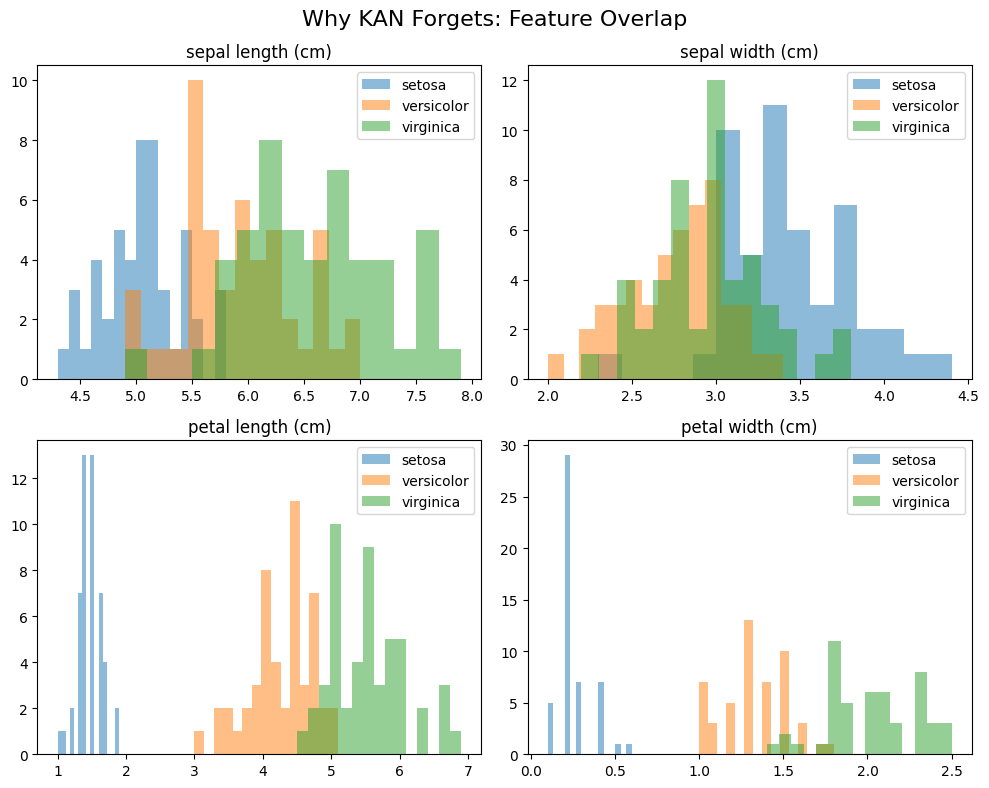

In [12]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names

# Plot histograms to see overlap
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()

for i in range(4):
    for c, c_name in zip([0, 1, 2], iris.target_names):
        subset = X[y == c, i]
        axs[i].hist(subset, alpha=0.5, label=c_name, bins=15)
    axs[i].set_title(feature_names[i])
    axs[i].legend()

plt.suptitle("Why KAN Forgets: Feature Overlap", fontsize=16)
plt.tight_layout()
plt.show()